In [1]:
import torch
print('GPU not found.') if not torch.cuda.is_available() else print(f'Found GPU: {torch.cuda.get_device_name(0)}')

Found GPU: NVIDIA GeForce RTX 3070


In [2]:
# Cell 1: 라이브러리 import
import torch
from utils.cnn.classifier import initialize_cnn_classifier
from utils.cnn.dataset_functions import create_cnn_dataset, unwrap_client_data, get_label_mapping
from utils.cnn.federated_averaging import federated_averaging
from utils.cnn.visualization import plot_training_curves, visualize_predictions

In [3]:
# Cell 2: 데이터 경로 및 클라이언트 분배 설정 (수정 버전)
import random
import numpy as np

data_dir = 'data_train/'
imagePath0 = f'{data_dir}/0/'
imagePath1 = f'{data_dir}/1/'
npyPath = f'{data_dir}/annotations/'

# 파일 분배 설정
total_files = 1095
num_clients = 6
test_client_id = 6  # 테스트용 클라이언트 ID
test_data_ratio = 0.15  # 각 클라이언트에서 추출할 비율 (10%)

# 전체 파일 리스트 생성
all_files = [f'{i:06d}' for i in range(1, total_files + 1)]
random.shuffle(all_files)  # 랜덤 셔플 (선택사항)

# client6을 제외한 클라이언트에 데이터 분배
train_clients = [f'client{i}' for i in range(1, num_clients + 1) if i != test_client_id]
num_train_clients = len(train_clients)
files_per_train_client = len(all_files) // num_train_clients

clientIdentifierDict = {}
test_files = []  # client6에 들어갈 파일들

# 각 학습 클라이언트에 데이터 분배 및 테스트 데이터 추출
start_idx = 0
for i, client_id in enumerate(train_clients):
    if i < num_train_clients - 1:
        end_idx = start_idx + files_per_train_client
    else:
        end_idx = len(all_files)
    
    # 클라이언트에 할당된 파일들
    client_files = all_files[start_idx:end_idx]
    
    # 테스트 데이터 추출 (각 클라이언트에서 일정 비율)
    num_test_from_client = int(len(client_files) * test_data_ratio)
    test_files_from_client = random.sample(client_files, num_test_from_client)
    test_files.extend(test_files_from_client)
    
    # 남은 파일들을 클라이언트에 할당
    train_files = [f for f in client_files if f not in test_files_from_client]
    clientIdentifierDict[client_id] = train_files
    
    print(f'{client_id}: {len(train_files)}개 파일 (테스트로 {num_test_from_client}개 추출)')
    start_idx = end_idx

# client6에 테스트 파일 할당
clientIdentifierDict[f'client{test_client_id}'] = test_files
print(f'\nclient{test_client_id} (테스트): {len(test_files)}개 파일 (다양한 클라이언트에서 추출)')
print(f'총 학습 데이터: {sum(len(files) for k, files in clientIdentifierDict.items() if k != f"client{test_client_id}")}개')
print(f'총 테스트 데이터: {len(test_files)}개')

client1: 187개 파일 (테스트로 32개 추출)
client2: 187개 파일 (테스트로 32개 추출)
client3: 187개 파일 (테스트로 32개 추출)
client4: 187개 파일 (테스트로 32개 추출)
client5: 187개 파일 (테스트로 32개 추출)

client6 (테스트): 160개 파일 (다양한 클라이언트에서 추출)
총 학습 데이터: 935개
총 테스트 데이터: 160개


In [4]:
# Cell 3: 레이블 매핑 생성
label_mapping, num_classes = get_label_mapping(data_dir, clientIdentifierDict)

발견된 결함 유형 (0과 1 제외): [np.int8(-1), np.uint8(2), np.int8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.int8(7), np.uint8(8), np.uint8(9), np.uint8(11), np.uint8(14), np.uint8(255)]
레이블 매핑: {np.int8(-1): 0, np.uint8(2): 1, np.int8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.int8(7): 6, np.uint8(8): 7, np.uint8(9): 8, np.uint8(11): 9, np.uint8(14): 10, np.uint8(255): 11}
총 클래스 수: 12


In [5]:
# # 결함 유형 확인
# from utils.cnn.visual_npy import visualize_defect_types_samples

# visualize_defect_types_samples(data_dir, clientIdentifierDict, label_mapping, min_pixels=150)

In [6]:
# Cell 4: 데이터셋 생성
target_size = (640, 640)
print("\n데이터셋 생성 중...")
imageDict, labelDict = create_cnn_dataset(
    clientIdentifierDict,
    data_dir,
    target_size=target_size,
    label_mapping=label_mapping
)


데이터셋 생성 중...
client1...
  처리 중: 50/187 파일 완료
  처리 중: 100/187 파일 완료
  처리 중: 150/187 파일 완료
Contains 187 images...
Valid images: 184 (filtered 3 invalid labels)
Image Tensor Shape: torch.Size([184, 2, 640, 640])
client2...
  처리 중: 50/187 파일 완료
  처리 중: 100/187 파일 완료
  처리 중: 150/187 파일 완료
Contains 187 images...
Valid images: 185 (filtered 2 invalid labels)
Image Tensor Shape: torch.Size([185, 2, 640, 640])
client3...
  처리 중: 50/187 파일 완료
  처리 중: 100/187 파일 완료
  처리 중: 150/187 파일 완료
Contains 187 images...
Valid images: 181 (filtered 6 invalid labels)
Image Tensor Shape: torch.Size([181, 2, 640, 640])
client4...
  처리 중: 50/187 파일 완료
  처리 중: 100/187 파일 완료
  처리 중: 150/187 파일 완료
Contains 187 images...
Valid images: 180 (filtered 7 invalid labels)
Image Tensor Shape: torch.Size([180, 2, 640, 640])
client5...
  처리 중: 50/187 파일 완료
  처리 중: 100/187 파일 완료
  처리 중: 150/187 파일 완료
Contains 187 images...
Valid images: 179 (filtered 8 invalid labels)
Image Tensor Shape: torch.Size([179, 2, 640, 640])
client

In [7]:
# Cell 5: Train/Test 분할
trainClients = ['client1', 'client2', 'client3', 'client4', 
                'client5']
testClients = ['client6']

clientIDs = trainClients

# Train Data
trainImageDict = {clientID: imageDict[clientID] for clientID in trainClients}
trainLabelDict = {clientID: labelDict[clientID] for clientID in trainClients}

# Test Data
testImageDict = {clientID: imageDict[clientID] for clientID in testClients}
testLabelDict = {clientID: labelDict[clientID] for clientID in testClients}

testImages, testLabels = unwrap_client_data(testImageDict, testLabelDict, testClients)


In [8]:
# # 레이블 검증
# print("\n레이블 범위 검증:")
# for clientID in clientIDs:
#     labels = trainLabelDict[clientID]
#     min_label = labels.min().item()
#     max_label = labels.max().item()
#     invalid_count = ((labels < 0) | (labels >= num_classes)).sum().item()
#     print(f"{clientID}: min={min_label}, max={max_label}, invalid={invalid_count}")
#     if invalid_count > 0:
#         print(f"  경고: {clientID}에 유효하지 않은 레이블이 {invalid_count}개 있습니다!")

In [ ]:
# Cell 6: 하이퍼파라미터 설정
SERVER_ROUNDS = 3
LOCAL_EPOCHS = 1
LOCAL_BATCH_SIZE = 32
LOCAL_LEARNING_RATE = 1e-4
EARLY_STOPPING_ACCURACY = 90.0

In [10]:
# Cell 7: 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = initialize_cnn_classifier(num_classes, input_channels=2, device=device)
print(f"모델 초기화 완료! 클래스 수: {num_classes}")


모델 초기화 완료! 클래스 수: 12


In [11]:
# Cell 8: 연합학습 실행
model, serverStateDict, lossDict, testLoss, accuracyDict, testAccuracy = federated_averaging(
    model,
    SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE, LOCAL_LEARNING_RATE,
    clientIDs, trainImageDict, trainLabelDict,
    testImages, testLabels,
    num_classes,
    device=device,
    early_stopping_accuracy=EARLY_STOPPING_ACCURACY
)

------ Server Round 0 ------

Running local updates for client1...
Epoch 1/1 - Loss: 2.4866, Accuracy: 8.15%
Saving local updates for client1...

Running local updates for client2...
Epoch 1/1 - Loss: 2.4815, Accuracy: 6.49%
Saving local updates for client2...

Running local updates for client3...
Epoch 1/1 - Loss: 2.4824, Accuracy: 7.18%
Saving local updates for client3...

Running local updates for client4...
Epoch 1/1 - Loss: 2.4867, Accuracy: 6.67%
Saving local updates for client4...

Running local updates for client5...
Epoch 1/1 - Loss: 2.4837, Accuracy: 6.70%
Saving local updates for client5...

Performing Server Update...
Done...
Assigning current server state to the global model...
Evaluating Test Set Performance...
Test Loss: 2.4771, Test Accuracy: 12.18%
Done...

------ Server Round 1 ------

Running local updates for client1...
Epoch 1/1 - Loss: 2.4772, Accuracy: 9.78%
Saving local updates for client1...

Running local updates for client2...
Epoch 1/1 - Loss: 2.4722, Accura

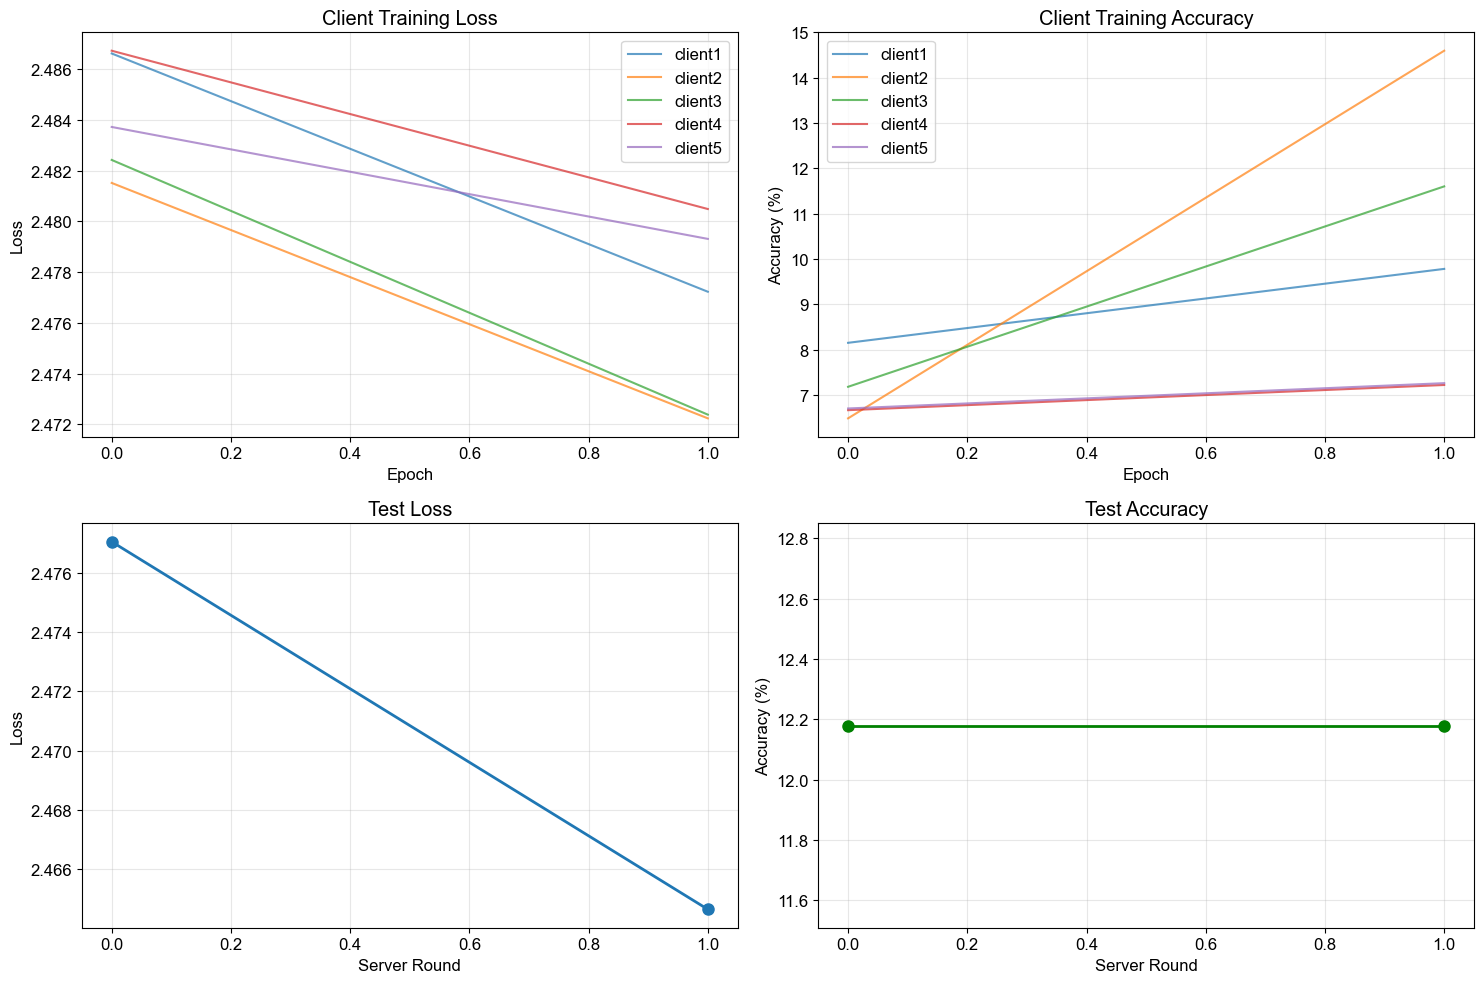

In [12]:
# Cell 9: 학습 곡선 시각화
plot_training_curves(lossDict, accuracyDict, testLoss, testAccuracy, clientIDs)


In [13]:
# Cell 10: 모델 저장
import os
from utils.cnn.classifier import save_cnn_model

os.makedirs('saved_models', exist_ok=True)

test_set_name = ''.join([c.replace('client', '') for c in testClients])
if len(test_set_name) == 1:
    test_set_name = '0' + test_set_name

lr_str = f"{LOCAL_LEARNING_RATE:.0e}".replace('-', '').replace('+', '').replace('.0', '')
base_filename = f'saved_models/CNN_FL_{SERVER_ROUNDS}_{LOCAL_EPOCHS}_{LOCAL_BATCH_SIZE}_{lr_str}_HoldoutPart{test_set_name}.pth'

model_filename = base_filename
counter = 1
while os.path.exists(model_filename):
    base_name, ext = os.path.splitext(base_filename)
    model_filename = f'{base_name}_{counter}{ext}'
    counter += 1

save_cnn_model(model, model_filename, num_classes=num_classes)
print(f'\n최종 테스트 성능:')
print(f'  Loss: {testLoss[-1]:.4f}')
print(f'  Accuracy: {testAccuracy[-1]:.2f}%')


모델이 saved_models/CNN_FL_2_1_32_1e04_HoldoutPart06.pth에 저장되었습니다.

최종 테스트 성능:
  Loss: 2.4646
  Accuracy: 12.18%


In [16]:
# Cell 11: 예측 결과 시각화
visualize_predictions(
    model, testImageDict, testLabelDict, testClients,
    clientIdentifierDict, data_dir, num_samples=6, device=device
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.62 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 16.72 GiB is allocated by PyTorch, and 301.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)